I use all four variables, because I need them to help distinguish between Virginica and Versicolor, which have some overlap.

This is setup for both models.

In [36]:
# Note: Consider using more than 2 features

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, metrics, model_selection

# Setup code for both versions, professor and keras

X, y = datasets.load_iris(return_X_y=True)

# X = X[:, 2:4]
#  np.stack((X[:, 0], X[:, 2]), axis=1)  # keeping the two features I'm using
Y = np.eye(3)[y]  # Adjusting for red-hot

This is based on the professor's code. It doesn't have a train/test split.

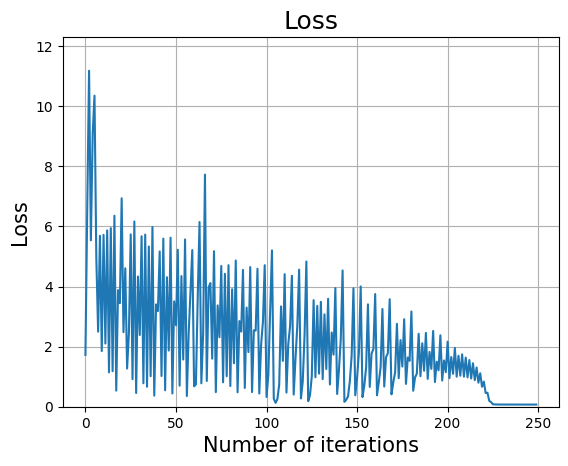

0.07157869014956354


In [37]:
LEARNING_RATE = 0.5
NUM_EPOCHS = 250
NUM_POINTS = len(X)
NUM_FEATURES = len(X[0])

# I'm noting here everything I do to make it 4 columns
# First I commented out above where I made X only 2 columns
# Then I changed the places where it said 2 to 4, replacing it with a variable


def softmax(a):
    return np.exp(a-max(a)) / np.sum(np.exp(a-max(a)))


def forward_propagate(x, W, b):
    # W is 3 x 2
    # x is 2 x 1
    # b is 3 x 1
    z = np.matmul(W, x) + b
    a = softmax(z)
    # z is 3 x 1
    # a is 3 x 1
    return z, a


def get_loss_numerically_stable(y, z):
    return -1 * np.sum(y * (z + (-z.max() - np.log(np.sum(np.exp(z-z.max()))))))

def get_gradients(x, z, a, y):
    da = (-y / a)

    matrix = np.matmul(a, np.ones((1, 3))) * (np.identity(3) - np.matmul(np.ones((3, 1)), a.T))
    dz = np.matmul(matrix, da)

    dW = dz * x.T
    db = dz.copy()

    return dz, dW, db

def gradient_descent(W, b, dW, db, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return W, b

# random initialization
W_initial = np.random.rand(3, NUM_FEATURES)
W = W_initial.copy()
b = np.zeros((3, 1))

W_cache = []
b_cache = []
L_cache = []

# for each EPOCH (i.e. each pass through training data)
for i in range(NUM_EPOCHS):
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)
    L = 0
    # for each training example 0..20
    for j in range(X.shape[0]):
        x_j = X[j,:].reshape(NUM_FEATURES,1)
        y_j = Y[j,:].reshape(3,1)

        z_j, a_j = forward_propagate(x_j, W, b)
        loss_j = get_loss_numerically_stable(y_j, z_j)
        dZ_j, dW_j, db_j = get_gradients(x_j, z_j, a_j, y_j)

        dW += dW_j
        db += db_j
        L += loss_j

    dW *= (1.0/NUM_POINTS)
    db *= (1.0/NUM_POINTS)
    L *= (1.0/NUM_POINTS)

    # after computing and averaging the gradient updates for this EPOCH
    # update our weights by the specified gradient moderating it by our
    # learning rate.
    W, b = gradient_descent(W, b, dW, db, LEARNING_RATE)

    W_cache.append(W)
    b_cache.append(b)
    L_cache.append(L)

plt.grid()
plt.title('Loss', size=18)
plt.xlabel('Number of iterations', size=15)
plt.ylabel('Loss', size=15)
plt.ylim([0, max(L_cache) * 1.1])
plt.plot(L_cache)
plt.show()

print(L_cache[-1])


I don't have a classifier line like last time, because I am using 4 independant variables. So, you will have to rely on accuracy and my confusion matrix.

Accuracy: 0.98


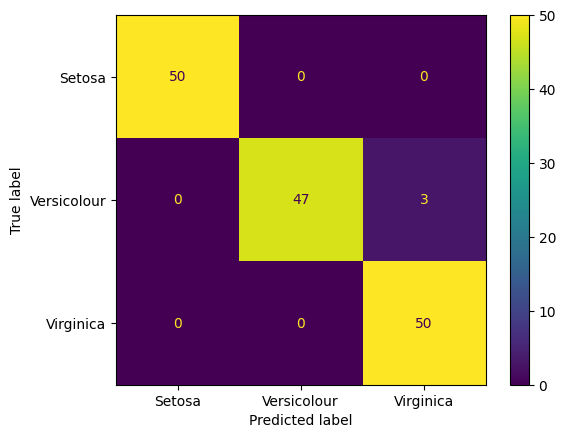

Setosa: Precision is 1.0 and recall is 1.0
Versicolour: Precision is 1.0 and recall is 0.94
Virginica: Precision is 0.9433962264150944 and recall is 1.0


In [38]:
# Go through the datapoints
# Determine the truthfulness of each point
# Get the ratio of true points to false points
predicted_vals = [np.argmax(forward_propagate(point.reshape(NUM_FEATURES,1), W, b)[1]) for point in X]
accuracy = metrics.accuracy_score(y, predicted_vals)
confusion_matrix = metrics.confusion_matrix(y, predicted_vals)
# sum(pred_y == real_y for pred_y, real_y in zip(predicted_vals, y)) / NUM_POINTS
# recall =

# print(forward_propagate(X[0].reshape(NUM_FEATURES,1), W, b))
print("Accuracy:", accuracy)
# print(confusion_matrix)
class_names = ["Setosa", "Versicolour", "Virginica"]
metrics.ConfusionMatrixDisplay.from_predictions(y, predicted_vals, display_labels=class_names)
plt.show()

def show_precision_recall(class_names, matrix):
    for row, name in enumerate(class_names):
        precision = matrix[row, row] / sum(matrix[:, row])
        recall = matrix[row, row] / sum(matrix[row, :])
        print(name + ": Precision is", precision, "and recall is", recall)

show_precision_recall(class_names, confusion_matrix)

This is my TensorFlow code. You might notice that the effectiveness of the model varies greatly based on which points are in the training group versus the validation group (unlike my original model which didn't use that split). This is because most of the challenge for the classifier comes from a small number of points. If any of those points aren't in the training set, it causes problems for the model (or, alternatively, if they are, my model is overfitting). I think this would be a problem where, due to its small number of points, k-fold cross-validation would be useful.

In [41]:
from tensorflow import keras as kr

# Since the exact train-test split affects performance greatly, I'm redoing it each time I run
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.1)
# I don't know of an easier way to get the result into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

number_of_classes = 3

model = kr.models.Sequential()
model.add(kr.layers.Dense(number_of_classes, activation='softmax', input_dim=NUM_FEATURES))
model.compile(optimizer=kr.optimizers.Adam(learning_rate=0.075), loss='categorical_crossentropy', metrics=[kr.metrics.CategoricalAccuracy()])
model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test))
# model.summary()
# print(model.weights)

Epoch 1/150
5/5 [==============================] - 1s 92ms/step - loss: 3.9178 - categorical_accuracy: 0.4074 - val_loss: 1.9597 - val_categorical_accuracy: 0.4000
Epoch 2/150
5/5 [==============================] - 0s 18ms/step - loss: 1.1761 - categorical_accuracy: 0.4667 - val_loss: 1.1798 - val_categorical_accuracy: 0.4000
Epoch 3/150
5/5 [==============================] - 0s 10ms/step - loss: 1.1789 - categorical_accuracy: 0.4074 - val_loss: 0.6557 - val_categorical_accuracy: 0.7333
Epoch 4/150
5/5 [==============================] - 0s 10ms/step - loss: 0.7083 - categorical_accuracy: 0.6593 - val_loss: 0.7374 - val_categorical_accuracy: 0.6000
Epoch 5/150
5/5 [==============================] - 0s 10ms/step - loss: 0.5244 - categorical_accuracy: 0.7556 - val_loss: 0.4919 - val_categorical_accuracy: 0.7333
Epoch 6/150
5/5 [==============================] - 0s 10ms/step - loss: 0.6069 - categorical_accuracy: 0.6593 - val_loss: 0.4763 - val_categorical_accuracy: 0.7333
Epoch 7/150
5/5 

5/5 [==============================] - 0s 3ms/step - loss: 0.0898 - categorical_accuracy: 0.9667


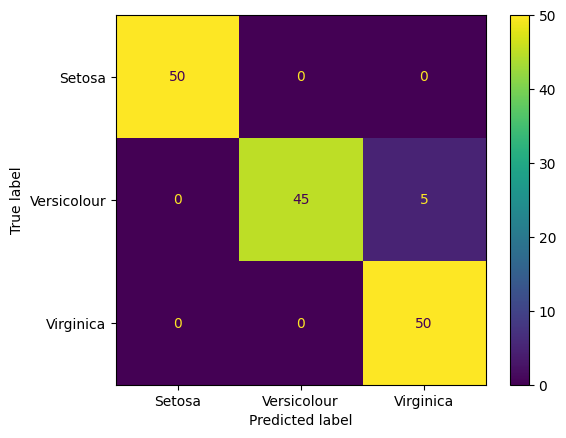

Setosa: Precision is 1.0 and recall is 1.0
Versicolour: Precision is 1.0 and recall is 0.9
Virginica: Precision is 0.9090909090909091 and recall is 1.0


In [42]:
model.evaluate(X, Y)
kr_predicted_vals = [np.argmax(point) for point in model.predict(X, verbose=0)]
# print(kr_predicted_vals)
metrics.ConfusionMatrixDisplay.from_predictions(y, kr_predicted_vals, display_labels=["Setosa", "Versicolour", "Virginica"])
plt.show()

kr_confusion_matrix = metrics.confusion_matrix(y, kr_predicted_vals)

show_precision_recall(class_names, kr_confusion_matrix)